In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
rand = np.random.rand

## Helper Functions

In [2]:
def assign_poles_to_bins(max_poles=5, bins=5):
    """Assign poles to frequency bins.  Each bin is assigned
    0,1, or 2 poles until max_poles is reached."""
    poles = [0]*bins
    
    for i in range(bins):
        num_poles = np.sum(poles)
        max_remaining = max_poles-num_poles
        if max_remaining == 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                poles[i] = 1
        else:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                poles[i] = 2
            elif r > 0.3:
                poles[i] = 1
        
    return poles

In [3]:
def assign_zeros_to_bins(poles):
    n = np.sum(poles)
    max_zeros = n-1
    bins = len(poles)
    zeros = [0]*bins
    
    for i, p_i in enumerate(poles):
        num_zeros = np.sum(zeros)
        max_remaining = max_zeros-num_zeros
        if p_i > 0:
            # no zeros in this bin 
            continue
        if max_remaining == 0:
            break
        elif max_remaining == 1:
            # the current bin can have 0 or 1 poles
            r = rand()
            if r > 0.5:
                zeros[i] = 1
        elif max_remaining > 1:
            # current bin can have 0, 1, or 2 poles
            r = rand()
            if r > 0.7:
                zeros[i] = 2
            elif r > 0.3:
                zeros[i] = 1
        
    return zeros
    

In [4]:
def random_log_freq(low_exponent):
    """Generate a random frequency on the range 10**low_exponent - 10**(low_exponent+1)"""
    high_exponent = low_exponent + 1
    mid_exp = (low_exponent+high_exponent)/2
    act_exp = mid_exp + 0.7*(rand()-0.5)
    freq = 10**act_exp
    return freq

In [5]:
def pole_bins_to_den(poles):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if poles[0] == 1:
        G = control.TransferFunction(1,[1,0])
    elif poles[1] == 2:
        G = control.TransferFunction(1,[1,0,0])
    else:
        G = 1
    
    for p_i, exp_i in zip(poles[1:], exponents[1:]):
        if p_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if p_i == 1:
            G_i = control.TransferFunction(1,[1,w_i])
        elif p_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction(1,[1,2*z_i*w_i,w_i**2])
            
        G *= G_i
        
    return np.squeeze(G.den)

In [6]:
def zero_bins_to_num(zeros):
    exponents = [None, -2, -1, 0, 1]# powers of 10 corresponding to each frequency bin
    
    if zeros[0] == 1:
        G = control.TransferFunction([1,0],1)
    elif zeros[1] == 2:
        G = control.TransferFunction([1,0,0],1)
    else:
        G = 1
    
    for z_i, exp_i in zip(zeros[1:], exponents[1:]):
        if z_i == 0:
            # skip
            continue
        freq_i = random_log_freq(exp_i)
        w_i = 2.0*np.pi*freq_i
        
        if z_i == 1:
            G_i = control.TransferFunction([1,w_i],1)
        elif z_i == 2:
            z_i = 0.8*rand()
            G_i = control.TransferFunction([1,2*z_i*w_i,w_i**2],1)
            
        G *= G_i
        
    return np.squeeze(G.num)

In [12]:
def random_Bode_TF(max_poles=5):
    plist = assign_poles_to_bins(max_poles=max_poles)
    zlist = assign_zeros_to_bins(plist)
    den = pole_bins_to_den(plist)
    num = zero_bins_to_num(zlist)
    G = control.TransferFunction(num,den)
    return G

In [13]:
def plot_bode(G, f=None):
    if f is None:
        f = np.logspace(-4,3,1000)
    w = 2.0*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    db = 20.0*np.log10(abs(Gjw))
    phase_rad = np.angle(Gjw)
    phase_rad = np.unwrap(phase_rad)
    phase = phase_rad*180.0/np.pi
    
    plt.figure()
    plt.subplot(211)
    plt.semilogx(f,db)
    plt.ylabel('dB Mag.')
    plt.subplot(212)
    plt.semilogx(f,phase)
    plt.ylabel('Phase (deg.)')
    plt.xlabel('Freq. (Hz)')

In [14]:
def steady_state_fixed_sine(G,f,input_amp=1.0):
    w = 2*np.pi*f
    s = 1.0j*w
    Gjw = G(s)
    m = abs(Gjw)*input_amp
    phi = np.angle(Gjw)
    y_ss = '%0.4g sin(2*pi*%0.4g %+0.4g)' % (m,f,phi)
    return y_ss

## Usage

The function `random_Bode_TF` takes one optional input, the maximum number of poles.  The default for max. poles is 5.

### Option 1: System ID

Generate a random TF and then plot is Bode.  Based on the Bode, estimate the TF.  Then, once you have an estimate of the TF, check the answer.

In [23]:
G = random_Bode_TF(3)

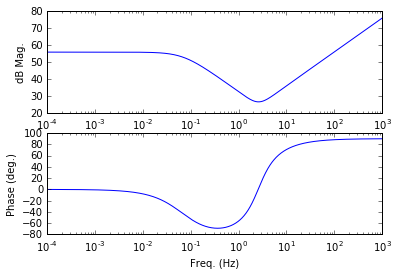

In [24]:
plot_bode(G)

#### Answer

In [25]:
G


s^2 + 20.96 s + 267.9
---------------------
      s + 0.4321

In [21]:
G.pole()

array([-181.06079942,   -0.3081315 ,    0.        ])

In [22]:
G.zero()

array([-1.18011821])

In [17]:
10**(-70/20)

0.00031622776601683794

In [21]:
-220/180*np.pi+2*np.pi

2.443460952792061

In [20]:
steady_state_fixed_sine(G,10)

'0.0004687 sin(2*pi*10 +2.323)'

In [166]:
20*np.log10(0.0214)

-33.391724533016188

In [167]:
1.0*180.0/np.pi

57.29577951308232